## Step 1: Data loading and cleaning

In [112]:
#list of imports we'll use later
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [113]:
#load our dataset and store a master copy so we dont have to read it again during testing
df_master = pd.read_csv("CSCS Data Anon.csv", low_memory=False)
df = df_master.copy()

In [114]:
#understand the general look of the data
print(df.shape)
df.head(20)

(11431, 1794)


,UNIQUE_id,UNIQUE_num_records,ELIGIBLE_consent,GEO_residence_canada,GEO_province,DEMO_age,DEMO_gender,DEMO_identity_vetrans,DEMO_identity_indigenous,DEMO_identity_lgbtq,...,PSYCH_body_self_image_questionnaire_height_dissatisfaction_score,PSYCH_body_self_image_questionnaire_fatness_evaluation_score,PSYCH_body_self_image_questionnaire_negative_affect_score,PSYCH_body_self_image_questionnaire_social_dependence_score,PSYCH_big_five_inventory_agreeable_score,PSYCH_big_five_inventory_conscientious_score,PSYCH_big_five_inventory_extraverted_score,PSYCH_big_five_inventory_neurotic_score,PSYCH_big_five_inventory_open_score,REMOVE_case
0,cscs_00001,1,Yes,Yes,British Columbia,71.0,Non-binary,NaN,NaN,"Sexual or gender minorities (e.g., LGBTQ2+)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1,cscs_00002,1,Yes,Yes,Ontario,69.0,Woman,NaN,NaN,Not Selected,...,3.0,8.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,No
2,cscs_00003,1,Yes,Yes,Quebec,56.0,Woman,NaN,NaN,Not Selected,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3,cscs_00005,1,Yes,Yes,NaN,54.0,Woman,NaN,NaN,Not Selected,...,NaN,NaN,NaN,NaN,28.0,34.0,30.0,32.0,37.0,No
4,cscs_00006,1,Yes,Yes,Ontario,30.0,Man,Not Selected,"Indigenous peoples (e.g., First Nations, Métis...","Sexual or gender minorities (e.g., LGBTQ2+)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5,cscs_00007,1,Yes,Yes,Ontario,55.0,Woman,NaN,NaN,Not Selected,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6,cscs_00008,1,Yes,Yes,NaN,50.0,Woman,NaN,NaN,Not Selected,...,NaN,NaN,NaN,NaN,30.0,30.0,17.0,31.0,43.0,No
7,cscs_00009,1,Yes,Yes,Ontario,52.0,Woman,NaN,NaN,Not Selected,...,15.0,15.0,15.0,11.0,NaN,NaN,NaN,NaN,NaN,No
8,cscs_00010,1,Yes,Yes,Nova Scotia,66.0,Man,Not Selected,Not Selected,"Sexual or gender minorities (e.g., LGBTQ2+)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
9,cscs_00011,1,Yes,Yes,British Columbia,76.0,Woman,NaN,NaN,"Sexual or gender minorities (e.g., LGBTQ2+)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [115]:
#look at what the inputs look like
df['CONNECTION_social_barriers_language'].value_counts()

CONNECTION_social_barriers_language
Not Selected                                         539
There is a language barrier between me and others     50
Presented but no response                             21
Name: count, dtype: int64

In [116]:
#clean na and "not answered" responses
df = df.dropna(subset=['CONNECTION_social_barriers_language'])
df = df[~df['CONNECTION_social_barriers_language'].isin(["Presented but no response"])]

In [117]:
#turn the word answers into a binary input (1 if the option was selected)
df.loc[:,'lang_barrier'] = df['CONNECTION_social_barriers_language'].map({"Not Selected": 0, "There is a language barrier between me and others": 1})
df['lang_barrier'].value_counts()

lang_barrier
0    539
1     50
Name: count, dtype: int64

In [118]:
#ensure we have no null values
print(df['lang_barrier'].isnull().sum())

0


In [119]:
#drop entries with no value for the number of close friends (even if they have an answer for language barrier, its no use if they dont report the number of friends they have)
df = df.dropna(subset=['CONNECTION_social_num_close_friends'])

In [120]:
#change the name, and trim our dataset to our required columns
df['close_friends'] = df['CONNECTION_social_num_close_friends']
df['drive_friend'] = df['CONNECTION_close_friends_same_area_15_min_drive'] #this is used later
df = df[['lang_barrier', 'close_friends', 'drive_friend']]

## Step 2: Visualization

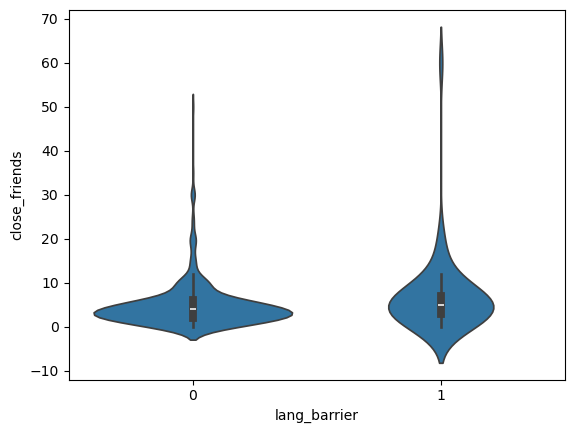

In [121]:
sns.violinplot(x='lang_barrier', y='close_friends', data=df)
plt.show()

Here we can see a little bit about the distribution for the number of close friends report based on if they feel a language barrier, however we have a lot of outliers that "smoosh" our dataset, making it hard to appreciate the differences. Lets trim the data to plot only the central 95% of the data.

In [122]:
Q1 = df['close_friends'].quantile(0.25)
Q3 = df['close_friends'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

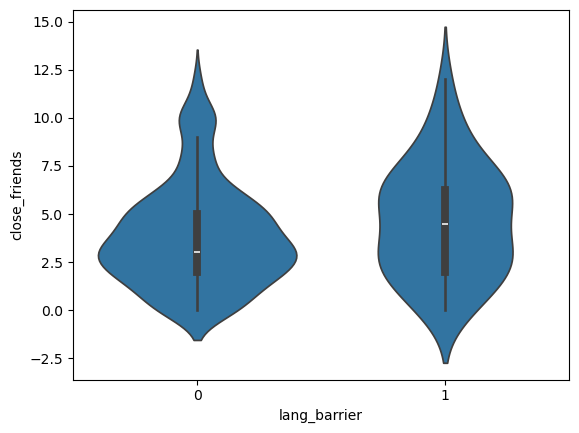

In [123]:
sns.violinplot(x='lang_barrier', y='close_friends', data=df[(df['close_friends'] >= lower_bound) & (df['close_friends'] <= upper_bound)])
plt.show()

This gives us a little bit more clarity on the majority of the data. Interestingly, although the spread of close friend count is a bit more spread out for the language barrier, it also seems like it might have a slightly larger mean.

In [124]:
print(df.groupby('lang_barrier')['close_friends'].describe())

              count      mean       std  min  25%  50%  75%   max
lang_barrier                                                     
0             530.0  4.809434  5.146209  0.0  2.0  4.0  6.0  50.0
1              49.0  6.775510  8.930904  0.0  3.0  5.0  7.0  60.0


Interestingly, it seems that this is true. We will examine more about this later in the analysis.

## Step 3: Analysis

Now that we have an idea of what the data looks like, lets see if we can test our hypothesis using statistical analysis. Our method of choice here will be permutation testing, which tests to see if the language barrier is present by randomizing the input, and seeing if that changes our outputs. Let us begin by getting a difference between the means of the groups (we saw this before).

In [125]:
observed_diff = df[df['lang_barrier'] == 1]['close_friends'].mean() - df[df['lang_barrier'] == 0]['close_friends'].mean()
print(observed_diff)

1.9660762418174818


Now we will perform our perm testing. Let us assume our null hypothesis is "there is no correlation between language barrier and the number of close friends someone has".

In [126]:
perm_diffs = []
    
for _ in range(10_000):
    # randomize the labels
    shuffled_labels = np.random.permutation(df['lang_barrier'])

    # create a new column with shuffled labels
    df.loc[:, 'shuffled_labels'] = shuffled_labels

    # calculate the difference in means between the two groups based on shuffled labels
    diff = df[df['shuffled_labels'] == 1]['close_friends'].mean() - df[df['shuffled_labels'] == 0]['close_friends'].mean()
    perm_diffs.append(diff)
    
np.array(perm_diffs)

array([-0.88767809, -0.04046977,  0.76214863, ..., -0.10735464,
        0.53919908,  0.31624952])

With this list of means, we will now plot them out, and try to construct a confidence interval (I have chosen the confidence interval to be 95%, which is standard). We are trying to see if our observed mean difference is within this interval, where we could accept our null hypothesis.

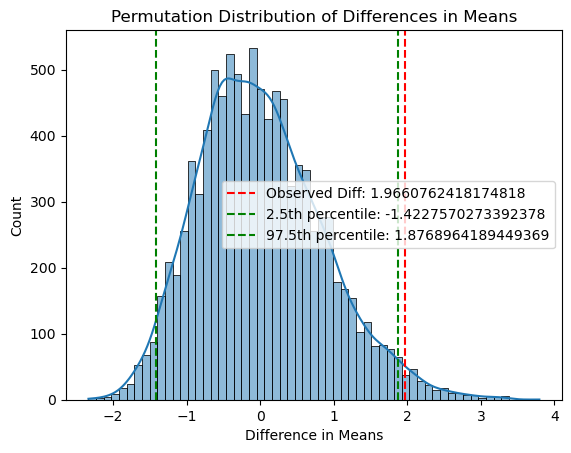

In [127]:
lower_ci = np.percentile(perm_diffs, 2.5)
upper_ci = np.percentile(perm_diffs, 97.5)
sns.histplot(perm_diffs, kde=True)
plt.axvline(observed_diff, color='red', linestyle='--', label=f'Observed Diff: {observed_diff}')
plt.axvline(lower_ci, color='green', linestyle='--', label=f'2.5th percentile: {lower_ci}')
plt.axvline(upper_ci, color='green', linestyle='--', label=f'97.5th percentile: {upper_ci}')
plt.title('Permutation Distribution of Differences in Means')
plt.xlabel('Difference in Means')
plt.legend()
plt.show()

From this, we can see that our observed difference does in fact lie outside of our interval, this means that we can safely reject our null hypothesis. This means that we can conclude that there is in fact a correlation between a language barrier and the number of friends that a person has.

In [128]:
p_value = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))
print(f"Observed Difference in Means: {observed_diff}")
print(f"P-value from Permutation Test: {p_value}")

Observed Difference in Means: 1.9660762418174818
P-value from Permutation Test: 0.0224


This analysis makes the same conclusion, with a p value less than 0.05 allowing us to reject the null hypothesis. However, why does a language barrier increase the number of close friends a person has?

## Part 4: Interpretation and Secondary Analysis

Initially, I assumed that a language barrier would cause friction in social interactions, and result in social isolation. So why is this not the case? I did some investigating on other columns in the dataframe. I'm investigating whether the ratio of close friends that live a short drive away is affected by language barrier. I want to see if the language barrier can cause people to potentially seek out friends further away from them due to a scarcity of speaking the same language as them.

In [129]:
df['drive_friend'].value_counts()

drive_friend
A few of them (i.e., 0-20%)           210
Some of them (i.e., 21-40%)            98
Around half of them (i.e., 41-60%)     82
Nearly all of them (i.e., 80-100%)     71
Most of them (i.e., 61-80%)            61
Presented but no response              57
Name: count, dtype: int64

In [130]:
df.loc[:,'drive_friend'] = df['drive_friend'].map({"A few of them (i.e., 0-20%)": 0.1, "Some of them (i.e., 21-40%)": 0.3, "Around half of them (i.e., 41-60%)":0.5, "Most of them (i.e., 61-80%)": 0.7, "Nearly all of them (i.e., 80-100%)":0.9})

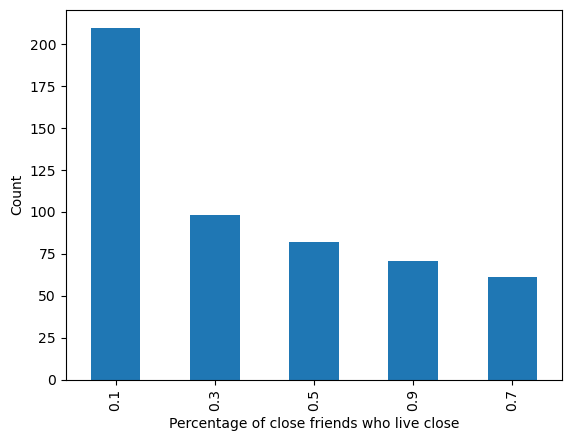

In [135]:
df['drive_friend'].value_counts().plot(kind='bar')
plt.xlabel('Percentage of close friends who live close')
plt.ylabel('Count')
plt.show()

Now I'll do the permutation testing again but with the new output category. Here our null hypothesis is similar, being "there is no correlation between the presence of a language barrier and the distance of close friends".

In [138]:
perm_diffs = []
    
for _ in range(10_000):
    # randomize the labels
    shuffled_labels = np.random.permutation(df['lang_barrier'])

    # create a new column with shuffled labels
    df.loc[:, 'shuffled_labels'] = shuffled_labels

    # calculate the difference in means between the two groups based on shuffled labels
    diff = df[df['shuffled_labels'] == 1]['drive_friend'].mean() - df[df['shuffled_labels'] == 0]['drive_friend'].mean()
    perm_diffs.append(diff)
    
np.array(perm_diffs)
observed_diff = df[df['lang_barrier'] == 1]['drive_friend'].mean() - df[df['lang_barrier'] == 0]['drive_friend'].mean()

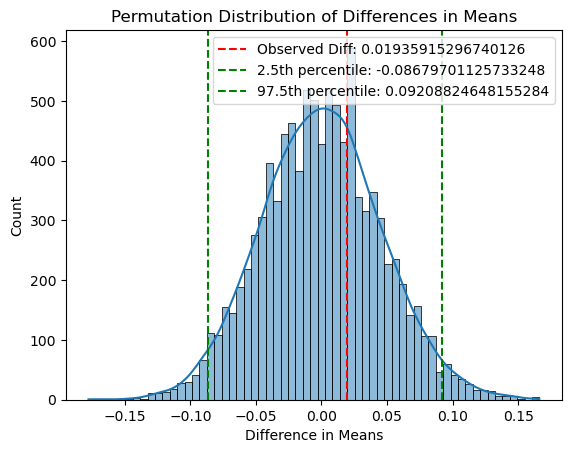

In [140]:
lower_ci = np.percentile(perm_diffs, 2.5)
upper_ci = np.percentile(perm_diffs, 97.5)
sns.histplot(perm_diffs, kde=True)
plt.axvline(observed_diff, color='red', linestyle='--', label=f'Observed Diff: {observed_diff}')
plt.axvline(lower_ci, color='green', linestyle='--', label=f'2.5th percentile: {lower_ci}')
plt.axvline(upper_ci, color='green', linestyle='--', label=f'97.5th percentile: {upper_ci}')
plt.title('Permutation Distribution of Differences in Means')
plt.xlabel('Difference in Means')
plt.legend()
plt.show()

Interestingly, here we see our observed difference fall right into our interval, which means that our null hypothesis is true, and there is no correlation. So the people who experience language barriers make more close friends in their community than those who don't.

To speculate about my results, I'm lead to believe that the reason why people with language barriers have more close friends is actually for the same reason I initially hypothesized. I think that with social isolation from communication issues, these people find stronger kinship between other people who speak their language, and maybe the fewer social interections might result in more meaningful ones. 
Another potential cause for language barriers could be cultural. It's unclear.